In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os
import tqdm
import glob
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import color

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.utils import to_categorical

In [36]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [39]:
from google.colab import drive

In [40]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
# Adjust the directory path
train_dataset = train_datagen.flow_from_directory(
    directory='/content/drive/MyDrive//Alzheimer_Dataset/train',
    target_size=(224, 224),
    class_mode='categorical',
    subset='training',
    batch_size=128
)

Found 4098 images belonging to 4 classes.


In [43]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive//Alzheimer_Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 254 images belonging to 4 classes.


100%|██████████| 5/5 [05:03<00:00, 60.72s/it]


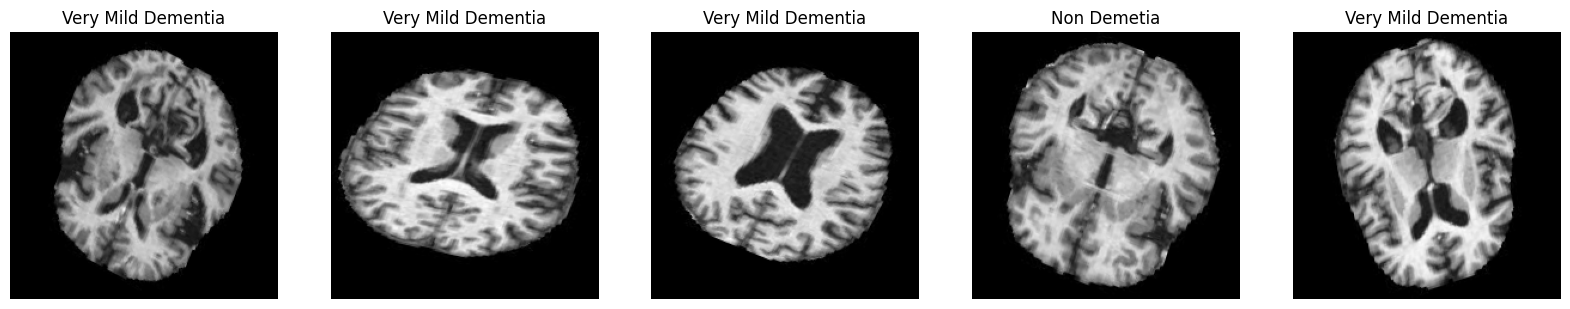

In [44]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [45]:
# Loading Model

base_model = VGG19(input_shape=(224,224,3),
                   include_top=False,
                   weights="imagenet")

80134624/80134624 [==============================] - 5s 0us/step


In [46]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [47]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (Batch  (None, 25088)             100352    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2048)              51382272  
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                       

In [48]:
# Model Compile

METRIC = tensorflow.keras.metrics.AUC(name = 'auc')

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)

In [49]:
# Defining Callbacks


filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc',
                              mode = 'max' ,
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [50]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 500,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/500
33/33 [==============================] - ETA: 0s - loss: 1.4747 - auc: 0.7527 
Epoch 1: val_auc improved from -inf to 0.71827, saving model to ./best_weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 1666s 50s/step - loss: 1.4747 - auc: 0.7527 - val_loss: 1.3481 - val_auc: 0.7183
Epoch 2/500
33/33 [==============================] - ETA: 0s - loss: 1.1777 - auc: 0.8085
Epoch 2: val_auc improved from 0.71827 to 0.78600, saving model to ./best_weights.hdf5
33/33 [==============================] - 78s 2s/step - loss: 1.1777 - auc: 0.8085 - val_loss: 1.0960 - val_auc: 0.7860
Epoch 3/500
33/33 [==============================] - ETA: 0s - loss: 1.0710 - auc: 0.8236
Epoch 3: val_auc improved from 0.78600 to 0.84787, saving model to ./best_weights.hdf5
33/33 [==============================] - 77s 2s/step - loss: 1.0710 - auc: 0.8236 - val_loss: 0.9055 - val_auc: 0.8479
Epoch 4/500
33/33 [==============================] - ETA: 0s - loss: 1.0272 - auc: 0.8344
Epoch 4: val_auc improved from 0.84787 to 0.86737, saving model to ./best_weights.hdf5
33/33 [==============================] - 80s 2s/step - loss: 1.0272 - auc: 0.8344 - val_loss: 0.8374 - val_au

In [52]:
# Load the best weights from the training
model.load_weights('./best_weights.hdf5')

In [53]:
# Evaluate the model on the test dataset
test_dataset = test_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/Alzheimer_Dataset/test',  # Adjust the path accordingly
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128,
    shuffle=False  # Set to False to maintain the order for evaluation
)

Found 1279 images belonging to 4 classes.


In [54]:
# Evaluate the model on the test dataset
test_results = model.evaluate(test_dataset)

10/10 [==============================] - 611s 68s/step - loss: 0.7895 - auc: 0.8986


In [55]:
# Save the entire model
model.save('/content/drive/MyDrive/Alzheimer_Dataset/AlzheimerVGG19_trained_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [59]:
# Generate predictions for the test set
y_pred = model.predict(test_dataset)

10/10 [==============================] - 6s 625ms/step


In [60]:
# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

In [61]:
# Get true labels
y_true = test_dataset.classes

In [62]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

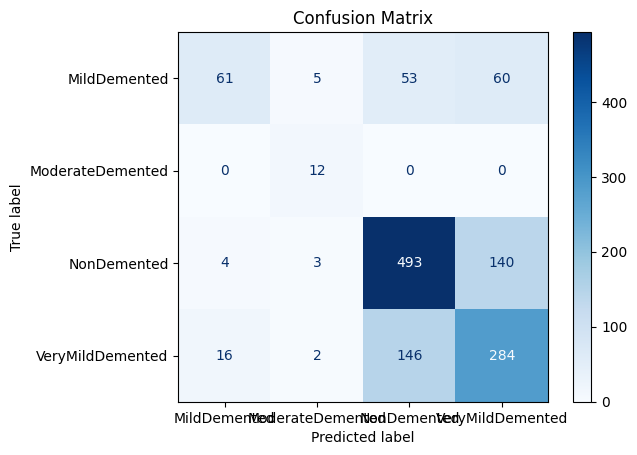

In [63]:
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=test_dataset.class_indices)
disp.plot(cmap=plt.cm.Blues, values_format='.0f')
plt.title('Confusion Matrix')
plt.show()

In [64]:
# Classification Report
class_report = classification_report(y_true, y_pred_labels, target_names=test_dataset.class_indices.keys())
print('Classification Report:\n', class_report)

Classification Report:
                   precision    recall  f1-score   support

    MildDemented       0.75      0.34      0.47       179
ModerateDemented       0.55      1.00      0.71        12
     NonDemented       0.71      0.77      0.74       640
VeryMildDemented       0.59      0.63      0.61       448

        accuracy                           0.66      1279
       macro avg       0.65      0.69      0.63      1279
    weighted avg       0.67      0.66      0.66      1279



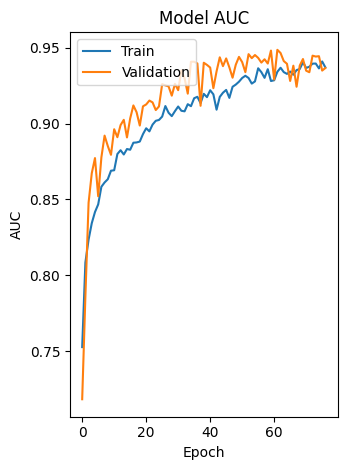

In [69]:
# Plot training & validation AUC values
plt.subplot(1, 2, 2)
plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

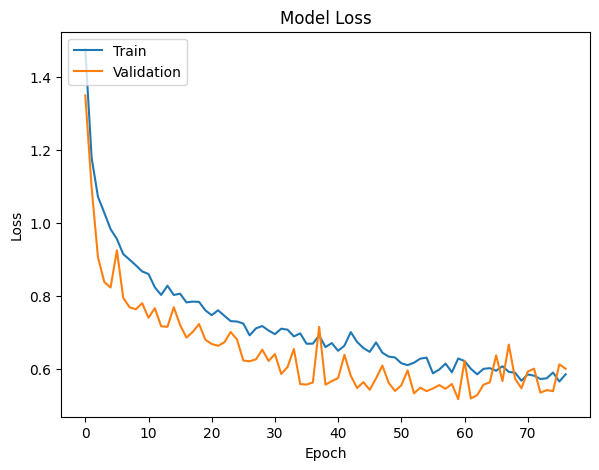

In [68]:
# Plot training & validation loss values along with AUC
plt.figure(figsize=(15, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')